In [ ]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install signate

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=75acf549a862f0f00cab8422548f4d53a247b50a8af5ae526bd206976f5d84ef
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
Download 100%.


In [ ]:
!signate list

  competitionId  title                                                                             closing     prize        submitters
---------------  --------------------------------------------------------------------------------  ----------  ---------  ------------
              1  【練習問題】銀行の顧客ターゲティング                                              -                              7373
             24  【練習問題】お弁当の需要予測                                                      -                              9038
             27  【練習問題】Jリーグの観客動員数予測                                               -                              2269
            100  【練習問題】手書き文字認識                                                        -           Knowledge           395
            102  【練習問題】タイタニックの生存予測                                                -           Knowledge          3311
            103  【練習問題】音楽ラベリング                                                        -           Knowledge           203
            

In [ ]:
! signate files --competition-id=1393

  fileId  name               title                               size  updated_at
--------  -----------------  --------------------------------  ------  -------------------
    2520  train.csv          学習用データ                      137862  2025-01-29 16:46:50
    2521  test.csv           評価用データ                       88524  2025-01-29 16:47:06
    2522  sample_submit.csv  サンプルサブミッション用ファイル   13006  2025-01-29 16:47:22


In [ ]:
!signate download --competition-id=1393

sample_submit.csv

test.csv

train.csv


Download completed.


### ライブラリ

In [ ]:
import pandas as pd
import numpy as np

# ヘッダ有りとヘッダ無しCSVに区別して読み取る
train_raw = pd.read_csv("/content/train.csv", header=0)
test_raw = pd.read_csv("/content/test.csv")
submission = pd.read_csv("/content/sample_submit.csv", header=None, names=["index", "Outcome"])

<Axes: xlabel='Pregnancies'>

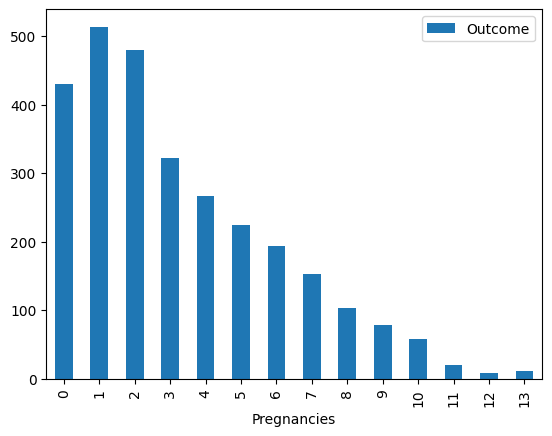

In [ ]:
# 妊娠回数と糖尿病の関係
EDA = train_raw[["Pregnancies","Outcome"]]
EDA.groupby(["Pregnancies"]).count().plot.bar()

In [ ]:
print(train_raw.shape)
print(test_raw.shape)
print(submission.shape)

(2861, 10)
(1919, 9)
(1919, 2)


In [ ]:
# データ型を確認
train_raw.columns

Index(['index', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [ ]:
# カテゴリ列と数値列を分類
# (今回は無いのでエンコード不要)
cat_col = []
num_col = []

for col in train_raw.columns:
  if col == 'object':
    cat_col.append(col)
  else:
    num_col.append(col)

print(f"In these features, there are {len(cat_col)} CATEGORICAL FEATURES: {cat_col}")

In [ ]:
# 欠損値を確認 (今回は無いので補完不要)
train_raw.isnull().sum()

,0
index,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [ ]:
# 特徴量以外を除去
RMV = ["index", "Outcome"]
FEATURES = [c for c in train_raw.columns if not c in RMV]

# ファイル結合、分離 (今回は不要)
combined = pd.concat([train_raw, test_raw], axis=0, ignore_index=True)

train = combined.loc[:len(train_raw)-1].copy()
test = combined.loc[len(train_raw):].reset_index(drop=True).copy()

# LightGBM ベースライン

In [ ]:
# LightGBMベースラインを作成する
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb

# LGBMパラメータ
lgbm_params = {
    "task": "train",
    "objective": "binary",
    "boosting": "gbdt",
    "num_boost_round": 1000,
    "learning_rate": 0.1,
    "device_type": "cpu",
    "seed": 1234,
    "metric": "binary_logloss"
    # "metric": "l1",
}

In [ ]:
%%time
FOLDS = 5 # 分割数
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# 検証用結果(valid)
oof_lgb = np.zeros(len(train))

# テスト用結果(test)
pred_lgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # 訓練データ
  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, "Outcome"]

  # 検証データ
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, "Outcome"]

  # テストデータ
  x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        valid_sets = lgb_eval,
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=10,
                            verbose = -1)],)

  # 予測
  # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  pred_lgb += model_lgb.predict(x_test)

# 平均評価
pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[LightGBM] [Info] Number of positive: 555, number of negative: 1733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 2288, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242570 -> initscore=-1.138641
[LightGBM] [Info] Start training from score -1.138641
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.383275
#########################
### Fold 2
#########################
[LightGBM] [Info] Number of positive: 532, number of negative: 1757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 547, number of negative: 1742
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 2289, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238969 -> initscore=-1.158340
[LightGBM] [Info] Start training from score -1.158340
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.427454
#########################
### Fold 5
#########################
[LightGBM] [Info] Number of positive: 537, number of negative: 1752
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 747
[LightGBM] [Info] Number of data points in the tra

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [ ]:
# モデルの評価
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# 検証予測の2値分類
y_val = []
for i, pred in enumerate(oof_lgb):
  if(pred>0.5):
    y_val.append(1)
  else:
    y_val.append(0)

y_true = train["Outcome"].tolist() # 正解
m = accuracy_score(y_val, y_true)  # 比較

print(f"/nOverall CV for LightGBM = ",m)

/nOverall CV for LightGBM =  0.8035651869975533


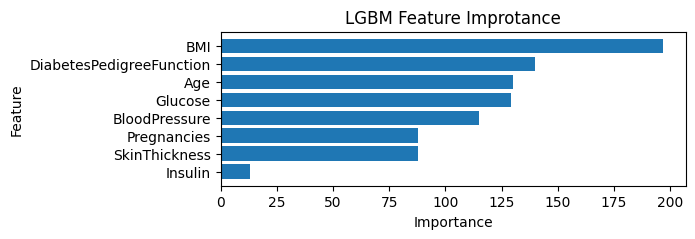

In [ ]:
# 重要度の図示
import matplotlib.pyplot as plt
feature_importance = model_lgb.feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(6, 2))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("LGBM Feature Improtance")
plt.gca().invert_yaxis()
plt.show()

# XGBoost ベースライン

In [ ]:
# XGBoostのベースライン
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb

In [ ]:
%%time
FOLDS = 5 # 分割数
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# 検証用結果(valid)
oof_xgb = np.zeros(len(train))

# テスト用結果(test)
pred_xgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # 訓練データ
  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, "Outcome"]

  # 検証データ
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, "Outcome"]

  # テストデータ
  x_test = test[FEATURES].copy()

  # 学習
  model_xgb = XGBClassifier(
      device = "cpu",
      objective = "binary:logistic",
      # max_depth = 3,
      # col_sample_bytree=0.5,
      # subsample = 0.8,
      # n_estimators = 2000,
      learning_rate = 0.1,
      # enable_categorical = True,
      seed = 1234,
      # min_child_weight = 80,
      n_estimators = 1000,
      early_stopping_rounds = 10,
  )

  # 訓練
  model_xgb.fit(x_train, y_train,
                eval_set=[(x_valid, y_valid)], verbose=10)

  # 予測
  oof_xgb[test_index] = model_xgb.predict(x_valid)
  pred_xgb += model_xgb.predict(x_test)

# 平均評価
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-logloss:0.51402
[10]	validation_0-logloss:0.43303
[20]	validation_0-logloss:0.40660
[30]	validation_0-logloss:0.39475
[40]	validation_0-logloss:0.38785
[50]	validation_0-logloss:0.38508
[60]	validation_0-logloss:0.38318
[70]	validation_0-logloss:0.38298
[73]	validation_0-logloss:0.38354
#########################
### Fold 2
#########################
[0]	validation_0-logloss:0.55645
[10]	validation_0-logloss:0.48632
[20]	validation_0-logloss:0.46852
[30]	validation_0-logloss:0.46231
[40]	validation_0-logloss:0.45473
[50]	validation_0-logloss:0.44834
[60]	validation_0-logloss:0.44259
[70]	validation_0-logloss:0.44047
[74]	validation_0-logloss:0.44000
#########################
### Fold 3
#########################
[0]	validation_0-logloss:0.51771
[10]	validation_0-logloss:0.44316
[20]	validation_0-logloss:0.41654
[30]	validation_0-logloss:0.40657
[40]	validation_0-logloss:0.40328
[50]	validation_0-logloss:0.4000

In [ ]:
# 検証予測の2値分類
y_val = []
for i, pred in enumerate(oof_xgb):
  if(pred>0.5):
    y_val.append(1)
  else:
    y_val.append(0)

y_true = train["Outcome"].tolist() # 正解
m = accuracy_score(y_val, y_true)  # 比較

print(f"/nOverall CV for XGBoost = ",m)

/nOverall CV for XGBoost =  0.8102062216008389


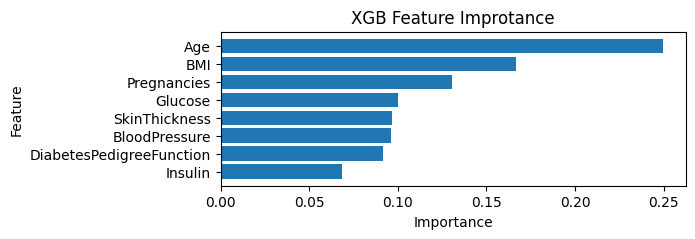

In [ ]:
# 重要度の図示
import matplotlib.pyplot as plt
feature_importance = model_xgb.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(6, 2))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGB Feature Improtance")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold

In [ ]:
class Model(nn.Module):
  def __init__(self, num_features):
    super(Model, self).__init__()

    self.num_features = num_features

    self.fc1 = nn.Linear(num_features, 256)
    self.bn1 = nn.BatchNorm1d(256, track_running_stats=True)

    self.fc2 = nn.Linear(256, 50)
    self.bn2 = nn.BatchNorm1d(50, track_running_stats=True)

    self.fc3 = nn.Linear(50, 1)

    self.drop = nn.Dropout(0.2)

  def forward(self, x):

    x = self.fc1(x)
    x = self.bn1(x)
    x = self.drop(x)
    x = torch.relu(x)

    x = self.fc2(x)
    x = self.bn2(x)
    x = torch.relu(x)

    return self.fc3(x)

In [ ]:
def train_model(model, train_loader, valid_loader, optimizer, criterion, device, epochs):

  for epoch in range(epochs):

    # 訓練モード
    model.train()

    for x, y in train_loader:
      x, y = x.to(device), y.to(device)

      # 最適化
      optimizer.zero_grad()

      # 予測
      output = model(x)

      # ロス関数
      loss = criterion(output, y)

      # 逆伝播
      loss.backward()

      # 1ステップ進む
      optimizer.step()

    model.eval()
    valid_loss = 0

    with torch.no_grad():

      for x, y in valid_loader:

        x, y = x.to(device), y.to(device)
        output = model(x)
        valid_loss += criterion(output, y).item()

    print(f"Epoch {epoch+1}, Validation Loss: {valid_loss/len(valid_loader)}")

In [ ]:
# cudaセッティング
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
EPOCHS = 4  # エポック数
REPEATS = 3 # 繰り返し計算数
FOLDS = 5   # 分割数
kf = KFold(n_splits=FOLDS, random_state=42, shuffle=True)

oof_nn = np.zeros(len(train)) # 検証結果
pred_nn = np.zeros(len(test)) # テスト結果

for r in range(REPEATS):
    print(f"### REPEAT {r+1} ###")

    # K分割
    for i, (train_index, test_index) in enumerate(kf.split(train)):
        print(f"### Fold {i+1} ###")

        # 訓練データ
        X_train = torch.tensor(train[train_index], dtype=torch.float32)
        y_train = torch.tensor(train.loc[train_index, "y"].values, dtype=torch.float32).unsqueeze(1) # 結合

        # 検証データ
        X_valid = torch.tensor(train[train_index], dtype=torch.float32)
        y_valid = torch.tensor(train.loc[test_index, "y"].values, dtype=torch.float32).unsqueeze(1) # 結合

        # テンソルデータセット
        train_dataset = TensorDataset(X_train, y_train)
        valid_dataset = TensorDataset(X_valid, y_valid)

        # データローダー
        train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=512)

        model = Model(len(FEATURES)).to(device) # モデル定義
        optimizer = optim.Adam(model.parameters(), lr=0.001) # 学習アルゴリズム
        criterion = nn.MSELoss() # 平均二乗誤差

        # 学習フェーズ
        train_model(model, train_loader, valid_loader, optimizer, criterion, device, EPOCHS)

        # 予測フェーズ
        model.eval()
        #ここから見直す
        with torch.no_grad():
            # 検証結果
            oof_nn[test_index] += model(X_valid_cats.to(device), X_valid_nums.to(device)).cpu().numpy().flatten()

        X_test_cats = torch.tensor(test[CATS].values, dtype=torch.long) # カテゴリ列
        X_test_nums = torch.tensor(test[NUMS].values, dtype=torch.float32) # 数値列
        with torch.no_grad():
            # テスト結果
            pred_nn += model(X_test_cats.to(device), X_test_nums.to(device)).cpu().numpy().flatten()

# 平均
oof_nn /= REPEATS
pred_nn /= (FOLDS * REPEATS)

### REPEAT 1 ###
### Fold 1 ###


KeyError: "None of [Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,\n       ...\n       2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860],\n      dtype='int64', length=2288)] are in the [columns]"

In [ ]:
average_pred = (pred_lgb + pred_xgb) / 2.0

In [ ]:
y_pred = []
for i, pred in enumerate(average_pred):
  if(pred>0.5):
    y_pred.append(1)
  else:
    y_pred.append(0)

In [ ]:
submission["Outcome"] = pd.DataFrame(y_pred)

In [ ]:
submission.columns = ['0', '1']

In [ ]:
submission.to_csv("submission.csv", header=False, index=False)